# Extreme Gradient Boost


### Initialization

In [14]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

filename = "encoded_data_04_12.csv"
df = pd.read_csv(f"../DataSets/EncodedData/{filename}", sep=",", encoding="UTF-8")
df.head()

,name,height_in_cm,year,goals_for,goals_against,goals,assists,red_cards,yellow_cards,minutes_played,market_value_in_eur,age_at_evaluation,log_market_value_base10,country_of_citizenship_encoded,sub_position_encoded,club_id_encoded,domestic_competition_id_encoded
0,Miroslav Klose,184.0,2012.75,31.0,14.0,11.0,1.0,0.0,6.0,1483.0,4000000.0,35,6.60206,7.483360e+06,5.677233e+06,8.444111e+06,7.840140e+06
1,Miroslav Klose,184.0,2013.25,24.0,15.0,5.0,2.0,0.0,2.0,1102.0,2000000.0,35,6.30103,7.483360e+06,5.677233e+06,8.444111e+06,7.840140e+06
2,Miroslav Klose,184.0,2013.75,14.0,21.0,4.0,2.0,0.0,1.0,950.0,1000000.0,36,6.00000,7.483360e+06,5.677233e+06,8.444111e+06,7.840140e+06
3,Miroslav Klose,184.0,2014.25,24.0,22.0,4.0,3.0,0.0,1.0,1270.0,1000000.0,36,6.00000,7.483360e+06,5.677233e+06,8.444111e+06,7.840140e+06
4,Miroslav Klose,184.0,2014.75,31.0,18.0,4.0,3.0,0.0,2.0,496.0,1000000.0,37,6.00000,7.483360e+06,5.677233e+06,8.444111e+06,7.840140e+06


### Training and Prediction

In [28]:
X = df.drop(columns=['log_market_value_base10', 'name'])
y = df['log_market_value_base10']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

model = XGBRegressor(n_estimators=100, max_depth=8, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

print(X_test)

        height_in_cm     year  goals_for  goals_against  goals  assists  \
132489         168.0  2021.25       17.0           13.0    1.0      0.0   
122237         176.0  2020.25       17.0           19.0    0.0      2.0   
1874           177.0  2018.25       20.0           29.0    3.0      1.0   
121096         177.0  2023.75       15.0           23.0    2.0      1.0   
63349          185.0  2016.75        6.0            5.0    0.0      0.0   
...              ...      ...        ...            ...    ...      ...   
65969          175.0  2022.75       14.0           11.0    0.0      0.0   
94236          179.0  2018.25       35.0           26.0    3.0      5.0   
5082           177.0  2014.75       25.0           29.0    0.0      1.0   
41488          179.0  2019.75       28.0           23.0    4.0      1.0   
87763          185.0  2013.75        7.0            5.0    1.0      0.0   

        red_cards  yellow_cards  minutes_played  market_value_in_eur  \
132489        0.0          

In [46]:
z = pd.merge(X_test, df, on=['height_in_cm','year','goals_for','goals_against','goals','assists','red_cards','yellow_cards','minutes_played','age_at_evaluation','country_of_citizenship_encoded','sub_position_encoded','club_id_encoded','domestic_competition_id_encoded'])
z.head()

print(z.shape, X_test.shape, df.shape)

# Create a DataFrame with player names, real values, and predicted values
results_df = pd.DataFrame({
    'Name': z['name'],
    'Real_Value': y_test,
    'Predicted_Value': y_pred
})

# Sort the DataFrame by the predicted values in descending order
results_df_sorted = results_df.sort_values(by='Predicted_Value', ascending=False)

print(results_df_sorted)



(19333, 18) (15239, 15) (152389, 17)


ValueError: array length 15239 does not match index length 32684

### Model Performance

In [8]:
# Reverse normalization for actual values
y_test_original = np.power(10, y_test)

# Reverse normalization for predicted values
y_pred_original = np.power(10, y_pred)

# Calculate the mean squared error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')

# Calculate the mean squared percentage error
percentage_error = (mse / y_test_original.mean()) * 100
print(f'Mean squared Percentage Error: {percentage_error}%')


from sklearn.metrics import mean_absolute_percentage_error
result = mean_absolute_percentage_error(y_pred=y_pred_original, y_true=y_test_original)
print("Mean Absolute Percentage Error: ", result)

Mean Squared Error: 16153742043359.096
Mean squared Percentage Error: 315429519.8198264%
Mean Absolute Percentage Error:  0.41250513573659753


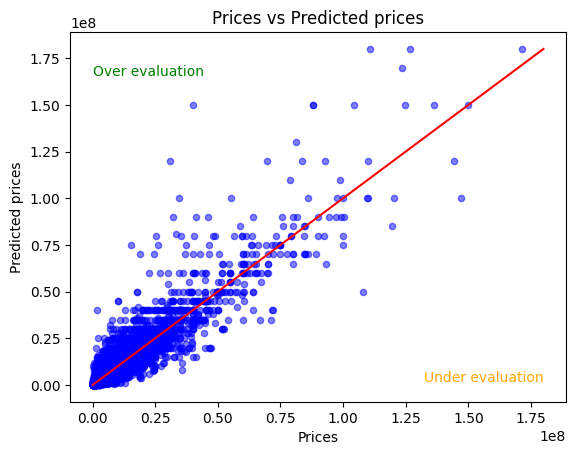

In [12]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(y_test_original, y_pred_original, s=20, color='blue', alpha=0.5)  # Set dot size to 20, blue color, and transparency to 0.5
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.title("Value vs Predicted value")

# Add diagonal line
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red')
plt.text(min(y_test_original), max(y_pred_original), "Over evaluation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test_original), min(y_pred_original), "Under evaluation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

plt.show()


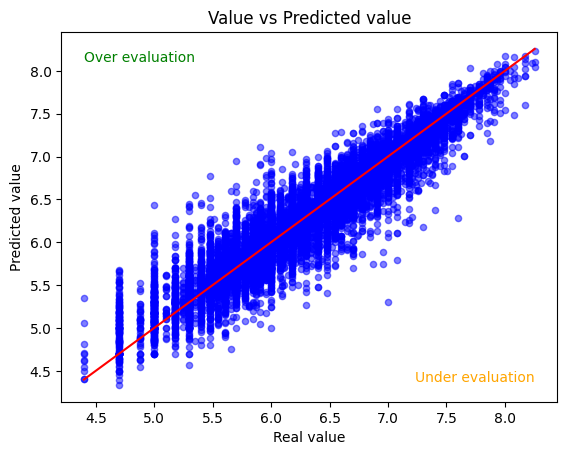

In [13]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(y_test, y_pred, s=20, color='blue', alpha=0.5)  # Set dot size to 20, blue color, and transparency to 0.5
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.title("Value vs Predicted value")

# Add diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.text(min(y_test), max(y_pred), "Over evaluation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test), min(y_pred), "Under evaluation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

plt.show()
